# How do socioeconomic factors affect crime in different neighborhoods in Baltimore?

## Introduction
This project seeks to explore the complex relationship between socioeconomic factors and crime rates across various neighborhoods in Baltimore. Utilizing data from January 1, 2012, to September 1, 2017, this analysis aims to uncover how economic indicators such as income level, employment status, and housing influence the prevalence and types of crimes committed in different areas of the city. We will investigate if individuals in economically disadvantaged positions may be more inclined to engage in property crimes as the perceived benefits outweigh the costs compared to those in more affluent circumstances. By correlating crime data with socioeconomic indicators, this project seeks to provide insights into the patterns and causes of crime, offering a nuanced understanding that can inform policy decisions and interventions. This investigation is grounded in the belief that a deeper understanding of the economic and social conditions contributing to crime can lead to more effective and equitable solutions for enhancing urban safety and community well-being.

The dataset used in this project was downloaded from [Kaggle](https://www.kaggle.com/datasets/sohier/crime-in-baltimore/data) and originially sourced from Open Baltimore's database of victim-based crimes. It contains data on every victim-based crime reported in Baltimore from January 1, 2012, to September 1, 2017. Each row contains information on the time, location, and details of a crime.

For Project One, we do not have access to socioeconomic data, as we are restricted to our one dataset. However, this project will make strides towards answering the broader research question by making observations about the frequency of violent and property crime in urban and suburban neighborhoods of Baltimore over time. For Project 2, we now have data for 

The independent variables in this project are 'CrimeDate' and 'DowntownStatus'. 'CrimeDate' measures the date on which a given crime occurred. This will help us analyze how crime rates interact with socioeconomic factors, as it will allow us to compare the crime level and economy conditions at a given point in time. 'DowntownStatus' will be our proxy for neighborhood, dividing the city into its downtown core (the Central, Western and Eastern districts) and the suburbs, using data from the 'District' and 'Neighborhood' columns. This will allow us to make observations about how socioeconomic factors affect urban and suburban neighborhoods differently.
Our dependent variable 'ViolentOrPropCrime' measures whether a crime was a violent or property crime and will allow us to see how socioeconomic factors effect the frequency of violent crime and property crime differently in different areas. This column will be formed based on data from the 'Description' column. In this project, we will be focused on identifying trends in the frequencies of each type of crime.

## Data Cleaning/Loading

In [704]:
# Loading libraries
import pandas as pd
import numpy as np

# Loading in dataset
df = pd.read_csv("/Users/ivangrandov/Downloads/BPD_Part_1_Victim_Based_Crime_Data.csv")
print(df.head())

    CrimeDate CrimeTime CrimeCode           Location          Description  \
0  09/02/2017  23:30:00       3JK    4200 AUDREY AVE  ROBBERY - RESIDENCE   
1  09/02/2017  23:00:00        7A  800 NEWINGTON AVE           AUTO THEFT   
2  09/02/2017  22:53:00        9S      600 RADNOR AV             SHOOTING   
3  09/02/2017  22:50:00        4C     1800 RAMSAY ST         AGG. ASSAULT   
4  09/02/2017  22:31:00        4E       100 LIGHT ST       COMMON ASSAULT   

  Inside/Outside   Weapon   Post  District      Neighborhood  Longitude  \
0              I    KNIFE  913.0  SOUTHERN          Brooklyn  -76.60541   
1              O      NaN  133.0   CENTRAL    Reservoir Hill  -76.63217   
2        Outside  FIREARM  524.0  NORTHERN    Winston-Govans  -76.60697   
3              I    OTHER  934.0  SOUTHERN  Carrollton Ridge  -76.64526   
4              O    HANDS  113.0   CENTRAL     Downtown West  -76.61365   

   Latitude                       Location 1     Premise  Total Incidents  
0  39.2295

In [705]:
# Drop columns we are not focusing on
cleaned_df = df.drop(columns=['CrimeTime','CrimeCode','Location','Inside/Outside','Weapon','Post','Location 1','Premise','Total Incidents'])
# Check for missing values
cleaned_df.isnull().sum()/len(cleaned_df.index)

CrimeDate       0.000000
Description     0.000000
District        0.000289
Neighborhood    0.009909
Longitude       0.007970
Latitude        0.007970
dtype: float64

In [706]:
# Drop rows with missing values
cleaned_df.dropna(subset=['CrimeDate','Description','District','Neighborhood','Longitude','Latitude'], inplace=True)
cleaned_df.isnull().sum()

CrimeDate       0
Description     0
District        0
Neighborhood    0
Longitude       0
Latitude        0
dtype: int64

In [707]:
# Make a new column that categorizes crimes into violent or property crimes
def categorize_crime(description):
    # Define the categories for violent crimes
    violent_crimes = ['ROBBERY - RESIDENCE', 'SHOOTING', 'AGG. ASSAULT', 'COMMON ASSAULT', 'HOMICIDE', 'ROBBERY - STREET', 'ROBBERY - COMMERCIAL', 'ROBBERY - CARJACKING', 'ASSAULT BY THREAT', 'RAPE']
    
    # Check and categorize each crime description
    if description.upper() in violent_crimes:
        return 1
    else:
        return 0

# Apply the function to each row in the 'Description' column to create the new column
cleaned_df['ViolentOrPropCrime'] = cleaned_df['Description'].apply(categorize_crime)

# Extract the neighborhoods from the downtown districts
downtown_neighborhoods_series = cleaned_df[cleaned_df['District'].isin(['WESTERN', 'EASTERN', 'CENTRAL'])].groupby('District')['Neighborhood'].unique()
# Turn series into a list
downtown_neighborhoods_list = sum([list(neighborhoods) for district, neighborhoods in downtown_neighborhoods_series.items()], [])

def categorize_by_location(neighborhood):
    # Define the downtown districts
    if neighborhood in downtown_neighborhoods_list:
        return 1
    else:
        return 0

# Apply the function to the 'Neighborhood' column to create a new column 'DowntownStatus'
cleaned_df['DowntownStatus'] = cleaned_df['Neighborhood'].apply(categorize_by_location)

# Standardize dating system to datetime format
cleaned_df['CrimeDate'] = pd.to_datetime(cleaned_df['CrimeDate'])

# Check cleaned data
print(cleaned_df.head())

   CrimeDate          Description  District      Neighborhood  Longitude  \
0 2017-09-02  ROBBERY - RESIDENCE  SOUTHERN          Brooklyn  -76.60541   
1 2017-09-02           AUTO THEFT   CENTRAL    Reservoir Hill  -76.63217   
2 2017-09-02             SHOOTING  NORTHERN    Winston-Govans  -76.60697   
3 2017-09-02         AGG. ASSAULT  SOUTHERN  Carrollton Ridge  -76.64526   
4 2017-09-02       COMMON ASSAULT   CENTRAL     Downtown West  -76.61365   

   Latitude  ViolentOrPropCrime  DowntownStatus  
0  39.22951                   1               0  
1  39.31360                   0               1  
2  39.34768                   1               0  
3  39.28315                   1               0  
4  39.28756                   1               1  


                 Neighborhood  Population  Housing  Occupied  Vacant  \
0                  Beechfield        4013     1721      1592     129   
1             Belair-Parkside         449      174       152      22   
2  Curtis Bay Industrial Area          20        1         1       0   
3                    Eastwood         764      286       272      14   
4     Forest Park Golf Course         358      135       123      12   

                                            geometry  DowntownStatus  
0  POLYGON Z ((1398129.136 588193.696 0.000, 1398...               0  
1  POLYGON Z ((1434761.523 605757.919 0.000, 1434...               0  
2  POLYGON Z ((1429250.879 569603.262 0.000, 1429...               0  
3  POLYGON Z ((1445409.058 592550.062 0.000, 1445...               0  
4  POLYGON Z ((1399118.761 603227.818 0.000, 1399...               0  


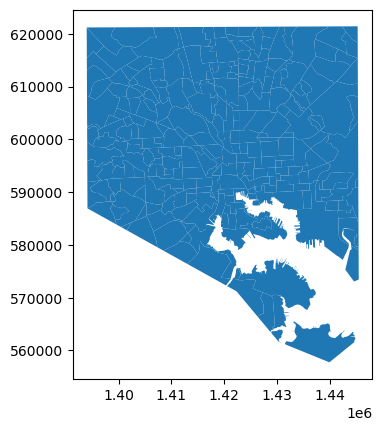

In [708]:
## Project 2 data
# Loading libraries
import geopandas as gpd
import zipfile
import os

# Loading geometric dataset
zip_path = '/Users/ivangrandov/Documents/GitHub/project-one-code-IvanGrandov/Data/Neighborhood.zip'
temp_dir = 'temp_shapefile'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

shp_file = [os.path.join(temp_dir, f) for f in os.listdir(temp_dir) if f.endswith('.shp')][0]

# Create gdf for the shapefiles
neighborhood_gdf = gpd.read_file(shp_file)
neighborhood_gdf.rename(columns={'Name': 'Neighborhood'}, inplace=True)
neighborhood_gdf = neighborhood_gdf.drop(columns=['OBJECTID','White','Blk_AfAm','Hisp_Lat','AmInd_AkNa','Asian','NatHaw_Pac','Other_Race','TwoOrMore','Shape__Are', 'Shape__Len'])
neighborhood_gdf.plot()

# Add DowntownStatus column to neighborhood_gdf
neighborhood_gdf['DowntownStatus'] = neighborhood_gdf['Neighborhood'].apply(categorize_by_location)
print(neighborhood_gdf.head())

# Create gdf for Baltimore crime data
from shapely.geometry import Point
crime_gdf = gpd.GeoDataFrame(cleaned_df, geometry=[Point(xy) for xy in zip(cleaned_df['Longitude'], cleaned_df['Latitude'])])

## Summary Statistics

In [709]:
print(cleaned_df.describe(include=['object']))

       Description      District Neighborhood
count       273789        273789       273789
unique          15             9          278
top        LARCENY  NORTHEASTERN     Downtown
freq         59982         42517         9048


From January 1, 2012 to September 2, 2017, a total of 273789 property and violent crimes were reported. The most common crime reported in Baltimore was Larceny, making up 59982 out of 273789 (~21.9%) crimes reported. The district with the most crime was the Northeastern district with 42517 crimes (~15.6%). The Neighborhood with the most crime was the Downtown neighborhood (not to be confused with the Downtown area as defined in this project) with 9048 crimes (~3.3%) occurring there over the sample period.

In [710]:
print(cleaned_df.describe(include=['int']))

       ViolentOrPropCrime  DowntownStatus
count       273789.000000   273789.000000
mean             0.393807        0.368375
std              0.488594        0.482365
min              0.000000        0.000000
25%              0.000000        0.000000
50%              0.000000        0.000000
75%              1.000000        1.000000
max              1.000000        1.000000


Because ViolentOrPropCrime and DowntownStatus are binary variables, these summary statistics represent the ratios of violent crime to property crime and downtown crime to non-downtown crime, respectively. ViolentOrPropCrime's mean of 0.394 suggests that 39.4% of crime committed during the sample period were violent. DowntownStatus's mean of 0.368 suggests that 36.8% of crime commited during the sample period occurred in downtown Baltimore.

In [711]:
# x1 variable (CrimeDate) value count
cleaned_df['CrimeDate'].value_counts()

2015-04-27    410
2016-06-05    254
2017-01-20    193
2016-09-24    192
2013-12-20    191
             ... 
2014-03-03     57
2015-03-05     54
2016-01-24     45
2014-02-13     44
2016-01-23     33
Name: CrimeDate, Length: 2072, dtype: int64

We see a huge outlier for crime on April 27, 2015, with a crime rate over 60% higher than the next highest date. A quick Google search led me to a [ABC news article](#https://abcnews.go.com/US/hundreds-people-clash-police-baltimore-mall/story?id=30622868) that mentions massive riots in the city following the killing of Freddie Gray by Baltimore Police Department.

In [712]:
# Analysis of crime on April 27, 2015
print(cleaned_df[cleaned_df['CrimeDate'] == '2015-04-27']['Description'].value_counts(), "\n")
print(cleaned_df[cleaned_df['CrimeDate'] == '2015-04-27']['ViolentOrPropCrime'].value_counts())

BURGLARY                207
AGG. ASSAULT             87
AUTO THEFT               31
LARCENY                  20
LARCENY FROM AUTO        14
ROBBERY - COMMERCIAL     13
COMMON ASSAULT           11
ARSON                    10
ROBBERY - STREET          8
ROBBERY - CARJACKING      6
ROBBERY - RESIDENCE       1
RAPE                      1
ASSAULT BY THREAT         1
Name: Description, dtype: int64 

0    282
1    128
Name: ViolentOrPropCrime, dtype: int64


The majority of crime committed during the Freddie Gray riots on April 27, 2015 were property crimes, and the most common crimes were Burglary and Aggrevated Assault. This is an interesting observation, and can potentially be used in future research using police brutality incidences as a social factor for crime.

In [713]:
# Frequency of y at different x2 values
print("DOWNTOWN", "\n", cleaned_df[cleaned_df['DowntownStatus'] == 1]['ViolentOrPropCrime'].describe(), "\n")
print("NON-DOWNTOWN", "\n", cleaned_df[cleaned_df['DowntownStatus'] == 0]['ViolentOrPropCrime'].describe())

DOWNTOWN 
 count    100857.000000
mean          0.435528
std           0.495828
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: ViolentOrPropCrime, dtype: float64 

NON-DOWNTOWN 
 count    172932.000000
mean          0.369475
std           0.482664
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: ViolentOrPropCrime, dtype: float64


Over the sample period, there were 100857 crimes reported in downtown and 172932 reported elsewhere in Baltimore. The most common type of crime in downtown Baltimore was property crime, with ~56.4% crimes being property crimes.
The most common type of crime in non-downtown Baltimore was also property crime, with ~63.1% crimes being property crimes.
Non-downtown Baltimore has a higher percentage of its crime being property crime than downtown Baltimore. In future research, we will attempt to find explanatory factors for this discrepancy.

In [714]:
# Frequency of x2 at different y values
print("VIOLENT CRIME", "\n", cleaned_df[cleaned_df['ViolentOrPropCrime'] == 1]['DowntownStatus'].describe(), "\n")
print("PROPERTY CRIME", "\n", cleaned_df[cleaned_df['ViolentOrPropCrime'] == 0]['DowntownStatus'].describe())

VIOLENT CRIME 
 count    107820.000000
mean          0.407401
std           0.491353
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: DowntownStatus, dtype: float64 

PROPERTY CRIME 
 count    165969.000000
mean          0.343022
std           0.474720
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: DowntownStatus, dtype: float64


Over the sample period, ~59.3% of violent crimes and ~65.7% of property crimes in Baltimore occured outside the downtown core. Both violent crime and property crime were more likely to occur outside of downtown. However, these are only gross figures that don't tell us about the crime rate per capita, which we will look at next.

In [715]:
def merge_with_crime_totals(df1, df2):
    # Total violent crimes by neighborhood
    violent_crimes = df1[df1['ViolentOrPropCrime'] == 1].groupby('Neighborhood').size().reset_index(name='TotalViolentCrimes')
    # Total property crimes by neighborhood
    property_crimes = df1[df1['ViolentOrPropCrime'] == 0].groupby('Neighborhood').size().reset_index(name='TotalPropertyCrimes')
    # Total crimes by neighborhood
    total_crimes = df1.groupby('Neighborhood').size().reset_index(name='TotalCrimes')
    # Merge
    df2 = df2.merge(total_crimes, on='Neighborhood', how='left')
    df2 = df2.merge(violent_crimes, on='Neighborhood', how='left')
    df2 = df2.merge(property_crimes, on='Neighborhood', how='left')
    # Per capita columns
    df2['CrimesPerCapita'] = df2['TotalCrimes'] / df2['Population']
    df2['ViolentCrimesPerCapita'] = df2['TotalViolentCrimes'] / df2['Population']
    df2['PropertyCrimesPerCapita'] = df2['TotalPropertyCrimes'] / df2['Population']
    return df2


merged_gdf = merge_with_crime_totals(crime_gdf, neighborhood_gdf)
merged_gdf = merged_gdf[merged_gdf['Population'] > 0]
# Per capita data for downtown
print('DOWNTOWN CRIME RATE')
merged_gdf[merged_gdf['DowntownStatus'] == 1].describe(include=['float'])

DOWNTOWN CRIME RATE


,TotalCrimes,TotalViolentCrimes,TotalPropertyCrimes,CrimesPerCapita,ViolentCrimesPerCapita,PropertyCrimesPerCapita
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,1542.508197,672.131148,870.377049,0.958502,0.383434,0.575069
std,1316.787184,595.763109,763.719433,1.242545,0.304195,0.970654
min,234.000000,52.000000,164.000000,0.183041,0.055659,0.127381
25%,739.000000,311.000000,428.000000,0.581599,0.256105,0.305373
50%,1185.000000,541.000000,654.000000,0.683894,0.328976,0.383191
75%,1930.000000,801.000000,1095.000000,0.859244,0.423282,0.506429
max,9048.000000,3973.000000,5075.000000,9.838617,2.175793,7.662824


The mean per capita crime rate for neighborhoods in downtown Baltimore was 0.96, with a standard deviation of 1.24 and median of 0.68. There is a significant difference between the min and max, with the most dangerous neighborhood in downtown having a crime rate over 54 times higher than the safest one. This all suggests that the overall crime rate varies drastically from neighborhood to neighborhood within downtown. The mean per capita violent crime rate was 0.38 with a std of 0.30 and median of 0.32. This suggests there is not much variance in the violent crime rate between these neighborhoods. The mean per capita property crime rate was 0.58 with a std of 0.97 and a median of 0.38. There is a drastic difference between the min and max, with the most dangerous neighborhood having a property crime rate nearly 64 times higher than the safest one. This suggests there is a lot of variation in property crime rates between downtown neighborhoods, and that property crime is responsible for the variance that we saw in the overall crime rate.

In [716]:
# Per capita data for non-downtown
print('NON-DOWNTOWN CRIME RATE')
merged_gdf[merged_gdf['DowntownStatus'] == 0].describe(include=['float'])

NON-DOWNTOWN CRIME RATE


,TotalCrimes,TotalViolentCrimes,TotalPropertyCrimes,CrimesPerCapita,ViolentCrimesPerCapita,PropertyCrimesPerCapita
count,183.000000,182.000000,183.000000,183.000000,182.000000,183.000000
mean,842.218579,311.296703,532.622951,0.956180,0.357848,0.600288
std,949.597501,391.327476,579.822856,3.373828,1.711791,1.805954
min,1.000000,1.000000,1.000000,0.017467,0.004367,0.013100
25%,290.500000,91.500000,202.500000,0.268206,0.078539,0.171795
50%,567.000000,198.500000,357.000000,0.366290,0.123185,0.226298
75%,960.000000,364.000000,624.500000,0.499430,0.201828,0.301904
max,6642.000000,2643.000000,3999.000000,40.062500,22.250000,17.812500


The mean per capita crime rate for neighborhoods in suburban Baltimore was 0.96, with a standard deviation of 3.37 and median of 0.37. There is a significant difference between the min and max, with the most dangerous neighborhood in downtown having a crime rate over 2350 times higher than the safest one. This all suggests that the overall crime rate varies drastically between these neighborhoods. The mean per capita violent crime rate was 0.36 with a std of 1.7 and median of 0.12. This suggests there is significant variance in the violent crime rate between these neighborhoods. The mean per capita property crime rate was 0.6 with a std of 1.81 and a median of 0.23. This suggests there is significant variation in property crime rates between suburban neighborhoods.

Comparing medians, downtown Baltimore has a higher overall crime rate, higher violent crime rate, and higher property crime rate. Comparing standard deviations, suburban Baltimore had more variance between neighborhoods in all three crime rate types than downtown Baltimore. It is also worth mentioning that the neighborhoods with the highest and lowest crime rates in all three categories were in suburban Baltimore. This could just be because the suburbs cover a greater area of the city, but there may be economic disparities driving crime that are more prevalent in the suburbs than in the city center.

## Data Visualization

In [717]:
# Import libraries
import matplotlib.pyplot as plt

# Aggregate counts by date (monthly) for each category and location
def aggregate_crimes_monthly(df1, status):
    # Filter based on DowntownStatus
    filtered_df = df1[df1['DowntownStatus'] == status]
    # Group by month and ViolentOrPropCrime, then count occurrences
    return filtered_df.groupby([pd.Grouper(key='CrimeDate', freq='M'), 'ViolentOrPropCrime']).size().unstack().fillna(0)

# Aggregate for Downtown and Elsewhere with monthly data
downtown_crimes_monthly = aggregate_crimes_monthly(cleaned_df, 1)
elsewhere_crimes_monthly = aggregate_crimes_monthly(cleaned_df, 0)
# Exclude September 2017 because it contains incomplete data that would skew the graph
downtown_crimes_monthly = downtown_crimes_monthly.loc[(downtown_crimes_monthly.index != '2017-09-30')]
elsewhere_crimes_monthly = elsewhere_crimes_monthly.loc[(elsewhere_crimes_monthly.index != '2017-09-30')]

# Plotting function
def plot_crimes(df, title):
    plt.figure(figsize=(6, 4))
    plt.plot(df.index, df[1], label='Violent Crimes', marker='o', linestyle='-', markersize=5)
    plt.plot(df.index, df[0], label='Property Crimes', marker='x', linestyle='-', markersize=5)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

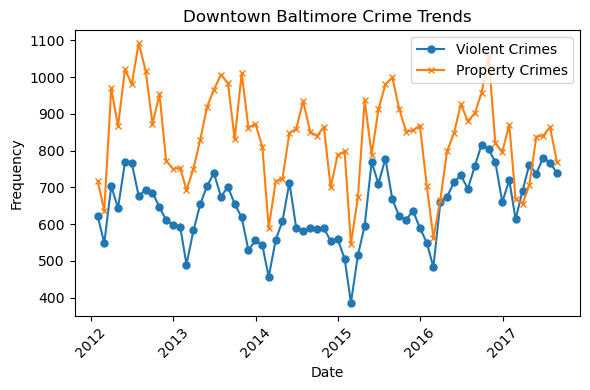

In [718]:
plot_crimes(downtown_crimes_monthly, 'Downtown Baltimore Crime Trends')

This graph displays the frequency of violent and property crimes in Downtown Baltimore over the sample period. To improve readibility, I aggregated the data monthly and set the bounds from 300 to 850. The datapoint for the number of crimes in a given month is mapped to the last day of that month (i.e. if there were 100 crimes committed in January 2024, there would be a point on January 31, 2024 with a Y-value of 100). I excluded the data for September 2017 because there were only entries for the first two days of the month, which made the data point for September 2017 unusable.

In general, the graph shows a seasonal pattern in violent and property crimes in downtown Baltimore. Violent crimes tends to peak in the late spring to early summer and are usually at their lowest in the late winter. However, this trend did not follow in 2016, as violent crime peaked in late summer to early fall. Property crime also tends to be at its lowest in late winter, but tends to peak later in late summer to early fall. The similarity in these seasonal trends suggests that property and violent crime share causal many factors.

We can observe the Freddie Gray riots as the property crime spike in April 2015. This spike is an outlier to the typical trend of property crime peaking in late summer. This suggest other such outliers may be caused by major events or policy changes, rather than a change in the typical seasonal factors.

We can observe overall crime levels decreasing from 2012 to 2014, then increasing thereafter. This trend is potentially explained by major socioeconomic trends over the time period.

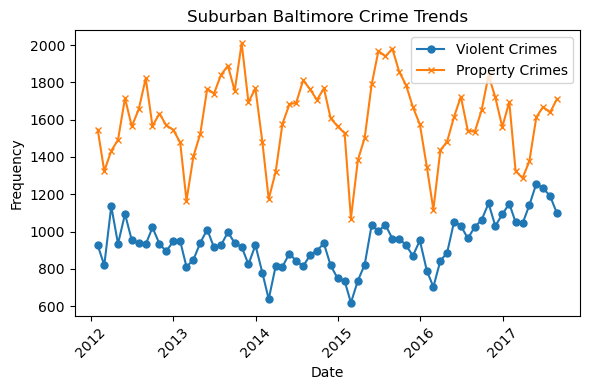

In [719]:
plot_crimes(elsewhere_crimes_monthly, 'Suburban Baltimore Crime Trends')

This graph displays the frequency of violent and property crimes in Suburban (Non-Downtown) Baltimore over the sample period. Like Downtown Baltimore, property crime in Suburban Baltimore follows a seasonal pattern. Property crime tends to peak in the summer to early fall and be at its lowest in late winter. However, violent crime's seasonal pattern is weaker. 2013, 2014, and 2015 show a seasonal pattern of peaks in the summer and early fall and low points in the late winter, but this trend does not follow for 2012 or 2017, where peaks were earlier in the year. This suggests that the factors that affect crime impact violent crime and property crime differently in suburban Baltimore.
We can also observe that the difference between property crime and violent crime is much greater in the suburbs than in downtown Baltimore.



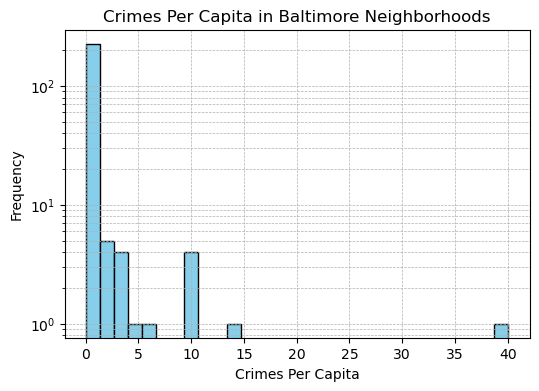

In [720]:
plt.figure(figsize=(6, 4))
plt.hist(merged_gdf['CrimesPerCapita'].dropna(), bins=30, color='skyblue', edgecolor='black')

plt.title('Crimes Per Capita in Baltimore Neighborhoods')
plt.xlabel('Crimes Per Capita')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.show()

The vast majority of neighborhoods in Baltimore have a very low crime rate. There are a few outliers with per capita crime rates greater than 10, but the frequency of near-zero crime rates is so great that a logarithmic y-scale is necessary to be able to see the rest of the data clearly. Though there are some exceptionally dangerous areas, most of Baltimore is relatively safe. More research is needed into why these outliers have such alarmingly high crime rates. Some possible explanations include an underreported neighborhood population and proximity to low-income housing.

# Project Two

## The Message
Criminality is ultimately a response to poor socioeconomic conditions which give individuals few other options. By understanding the connection between economic indicators and crime, governments can take more precise action towards alleviating these conditions and reducing crime.

### Importing New Dataset
I am importing a new dataset from [Open Baltimore](https://data.baltimorecity.gov/datasets/bniajfi::median-household-income/about?layer=0) which contains 2006-2021 Median Household Income data for different regions of Baltimore called Community Statistical Areas (CSAs). I will merge this data with the crime data and create a scatterplot, which I expect will show a correlation between lower household income and higher crime rates.

/Users/ivangrandov/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


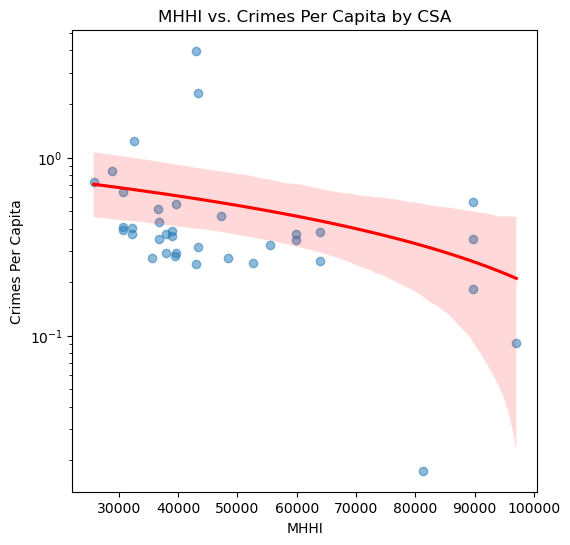

In [721]:
# Importing New Dataset
zip_path2 = '/Users/ivangrandov/Documents/GitHub/project-one-code-IvanGrandov/Data/Baltimore_Median_Household_Income.zip'
temp_dir2 = 'temp_shapefile2'

with zipfile.ZipFile(zip_path2, 'r') as zip_ref2:
    zip_ref2.extractall(temp_dir2)

shp_file2 = [os.path.join(temp_dir2, f) for f in os.listdir(temp_dir2) if f.endswith('.shp')][0]

# Create gdf for the CSA shapefiles
income_gdf = gpd.read_file(shp_file2)

# Calculate MHHI
income_gdf['MHHI'] = (income_gdf['mhhi17'] + income_gdf['mhhi16'] + income_gdf['mhhi15'] + \
                      income_gdf['mhhi14'] + income_gdf['mhhi13'] + income_gdf['mhhi12']) / 6

merged_gdf2 = gpd.sjoin(merged_gdf, income_gdf, how="left", op="within")

import seaborn as sns
# Scatter plot with regression line
plt.figure(figsize=(6, 6))
sns.regplot(x='MHHI', y='CrimesPerCapita', data=merged_gdf2, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})

plt.title('MHHI vs. Crimes Per Capita by CSA')
plt.xlabel('MHHI')
plt.ylabel('Crimes Per Capita')
plt.yscale('log')
plt.show()


I see negative correlation between the Median Household Income of a neighborhood and the crime rate of that neighborhood. The regression line slopes downwards, indicating that as MHHI increases, crime per capita tends to decrease, and vice versa. This observation justifies my earlier claim that poorer socioeconomic conditions lead to more crime and provides useful information for crime prevention policy. By knowing a root cause of criminality, lawmakers can directly address the problem through money transfer programs that create an income effect for the recipient. This would effectively raise the recipient's household income, thus decreasing their likelihood/economic incentive to commit crimes.

## Maps and Interpretations

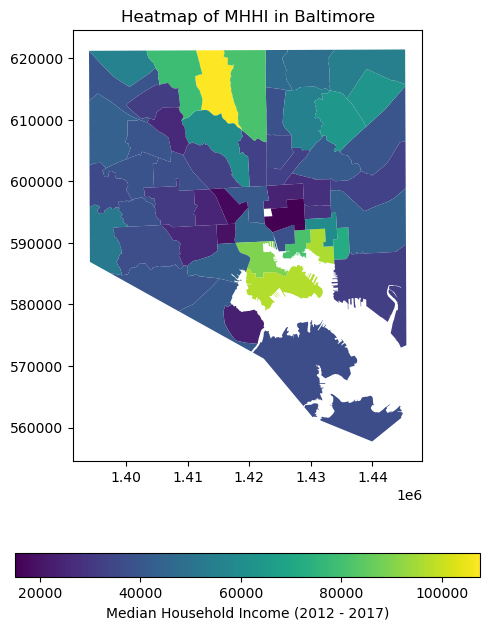

In [722]:
# Plotting the income heatmap
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
income_gdf.plot(column='MHHI', ax=ax, legend=True,
                legend_kwds={'label': "Median Household Income (2012 - 2017)",
                             'orientation': "horizontal"})

plt.title('Heatmap of MHHI in Baltimore')
plt.show()

This heat map displays the median household income of different CSA's in Baltimore. Because my crime data ranges from 2012 to 2017, I averaged the MHHIs from 2012 to 2017 to get the data that is plotted here. 
The distribution of wealth in Baltimore is quite unusual. In the downtown core of Baltimore, you can see both the richest and poorest areas on the map. One area with a MHHI of roughly $80k borders another area with a MMHI of only $20k. If we ignore the rich areas of downtown, we can notice a pattern of MHHI increasing as we move away from the city center. The suburbs, especially those on the north side of the city, are the wealthier area of Baltimore.

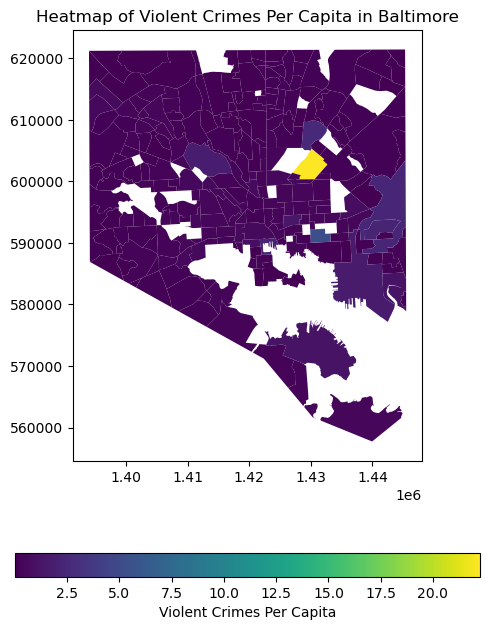

In [723]:
# Violent Crime Heatmap
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
heatmap = merged_gdf.plot(column='ViolentCrimesPerCapita', ax=ax, legend=True,
                          legend_kwds={'label': 'Violent Crimes Per Capita',
                                       'orientation': 'horizontal'})

plt.title('Heatmap of Violent Crimes Per Capita in Baltimore')
ax.set_frame_on(True)

plt.show()

This is a heatmap of violent crime per capita in Baltimore. As we saw before with the histogram, the vast majority of neighborhoods in Baltimore have low crime rates and there are a handful of outlier neighborhoods with very high crime rates. Most of the map is the same shade of dark purple, but I notice some lighter purple on the east side of the city, signifying a slightly higher violent crime rate. Near the middle of the map is a bright yellow neighborhood, signifying a violent crime rate multitudes higher than the rest of the city. When we compare this outlier to the income map, we see that the area is a middle class neighborhood, which is puzzeling because the correlation between crime and poverty would lead us to believe this must be one of the poorest neighborhoods. Since that isn't the case, I should continue to investigate this area in future projects to uncover the reason for this anomaly.

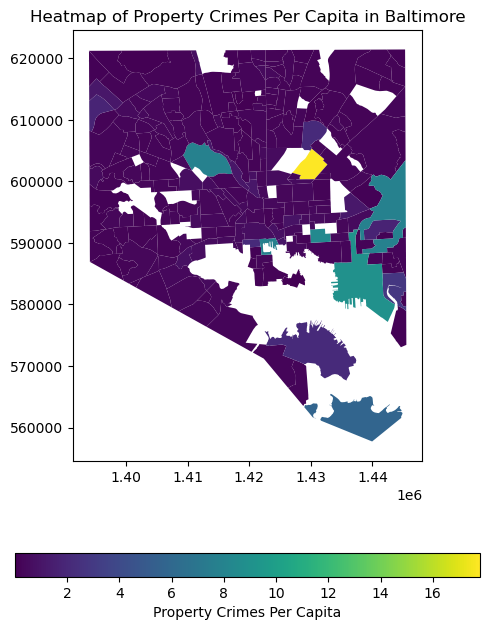

In [724]:
# Property Crime Heatmap
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
heatmap = merged_gdf.plot(column='PropertyCrimesPerCapita', ax=ax, legend=True,
                          legend_kwds={'label': 'Property Crimes Per Capita',
                                       'orientation': 'horizontal'})

plt.title('Heatmap of Property Crimes Per Capita in Baltimore')
ax.set_frame_on(True)

plt.show()

This is a heatmap of property crime per capita in Baltimore. On this map, there seems to be more varience in crime rates from neighborhood to neighborhood compared to the violent crime map. Once again, we see the bright yellow neighborhood, but now there are light teal neighborhoods as well in the Southern, Eastern, and Northwestern sides of the city. These neighborhoods are the same ones that were a light purple on the violent crime map, signifying that the conditions that drive individuals to criminality impact both violent and property crime rates, though not necessarily to an equal extent. Comparing these neighborhoods to the income map, I found that though these neighborhoods were lower-middle class at best, they were far from the poorest neighborhoods in the city. I was surprised to find that the poorest neighborhoods tended not to have very high crime rates. However, I did find that wealthy neighborhoods that bordered very poor neighborhoods tended to have a high rate of property crime.

## Conclusion
The analysis of crime trends in Baltimore, focusing on the distinction between Downtown and Non-Downtown areas, reveals significant insights into the dynamics of violent and property crimes across different urban landscapes. We identified seasonal trends in both types of crime and in both types of neighborhoods, which gives us valuable insight into the socioeconomic trends that influence these crime rates. The comparison between these areas underscores the variability in crime rates, with Downtown Baltimore exhibiting distinct patterns that potentially reflect the unique socio-economic and environmental factors inherent to densely populated commercial hubs. Notably, the trends indicate that while certain types of crimes may fluctuate seasonally, underlying factors such as major political movements, policy changes, and current events play crucial roles in shaping these patterns over time. The distinction between violent and property crimes furthers our understanding of how different drivers may influence various types of criminal activity in urban settings.

The scatterplot regression highlighted the significant impact that economic status has on rates of criminality. However, the findings from our heatmap analysis have shown that there are many more factors at play than simply income. Using the insights formed from the scatterplot analysis, it would have been logical to expect the poorest neighborhoods would be the ones with the most crime. However, we found that not to be the case. The neighborhoods with the highest crime were all middle to lower-middle class, but not the poorest of the poor. Future research will have to dig in further into the other factors that influence these counter-intuitive crime trends.

The findings of this study underscore the importance of targeted interventions and policies that address the specific needs and challenges of Downtown and Non-Downtown areas. For Downtown Baltimore, strategies that enhance surveillance, community policing, and socio-economic development could be pivotal in mitigating crime rates, particularly given the area's significance to the city's overall vitality. Meanwhile, addressing Non-Downtown crime requires a nuanced approach that considers the residential nature of these areas, focusing on building community initiatives that create safe environments. By leveraging detailed crime data and analytical insights, policymakers and community leaders can better allocate resources and evaluate the effectiveness of strategies to enhance public safety and community well-being across Baltimore.
